In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from scipy.integrate import solve_ivp

In [2]:
def prep_masks(n, cortices):
    cortex_mask = np.zeros_like(n)
    for i, cortex in enumerate(cortices):
        cortex_mask[cortex[0]:cortex[1], cortex[0]:cortex[1]] += i + 1
    G1 = n.copy()
    G1[cortex_mask == 0] = 0
    G2 = n.copy()
    G2[cortex_mask != 0] = 0
    events = [lambda t_in, y_in, i=i: event(t_in, y_in, i)
              for i in range(n.shape[0])]
    for e in events:
        e.direction = 1.0

    return G1, G2, events

In [3]:
def Θ(x, x_rev, λ, θ):
    xk, xj = np.meshgrid(x, x)
    return (xj - x_rev)/(1 + np.exp(-λ*(xk - θ)))

In [4]:
def dΘ_dx(x, λ, θ):
    final = np.ones((x.size, x.size))/(1 + np.exp(-λ*(x - θ)))
    np.fill_diagonal(final,
                     final.diagonal() +
                     x*λ*np.exp(-λ*(x - θ))/(1+np.exp(-λ*(x - θ)))**2)
    return final

In [5]:
def hr_dots(current, _, b, i0, x_rev, λ, θ, μ, s, x_rest,
            α, n1, β, n2, G1, G2):
    x, y, z = map(lambda k: k.flatten(), np.split(current, 3))
    theta = Θ(x, x_rev, λ, θ)
    dots = np.zeros_like(current).reshape(3, -1)
    dots[0] = y - (x**3) + b*(x**2) + i0 - z -\
        (α/n1)*np.sum(G1*theta, axis=1) - (β/n2)*np.sum(G2*theta, axis=1)
    dots[1] = 1 - 5*(x**2) - y
    dots[2] = μ*(s*(x - x_rest) - z)
    return np.hstack(dots)

In [6]:
def jac(_, y_in):
    x, y, z = map(lambda k: k.flatten(), np.split(y_in, 3))
    dtheta_dx = dΘ_dx(x, λ, θ)
    dẋ_dx = -3*x**2 + 2*b*x - (α/n1)*G1*dtheta_dx - (β/n2)*G2*dtheta_dx
    dẋ_dy = np.ones_like(dẋ_dx)
    dẋ_dz = -np.ones_like(dẋ_dy)

    dẏ_dx = -10*x*np.ones_like(dẋ_dz)
    dẏ_dy = -np.ones_like(dẏ_dx)
    dẏ_dz = np.zeros_like(dẏ_dy)

    dż_dx = μ*s*np.ones_like(dẏ_dz)
    dż_dy = np.zeros_like(dż_dx)
    dż_dz = -μ*np.ones_like(dż_dy)

    j_x = [dẋ_dx, dẋ_dy, dẋ_dz]
    j_y = [dẏ_dx, dẏ_dy, dẏ_dz]
    j_z = [dż_dx, dż_dy, dż_dz]

    return np.vstack([np.hstack(j_x), np.hstack(j_y), np.hstack(j_z)])

In [7]:
def cortex_size(mask, val):
    return int(np.sqrt(mask[mask == val].shape))

In [8]:
def plot_final_state(
    y,
    cortices=None, legend=False,
    title=None, channel=0,
    markers=["ro", "k^", "gX", "bD"],
    ylim=[-1.5, 2.5]
):
    if cortices is None:
        cortices = [[0, y.size]]
    m = iter(markers[:len(cortices)])
    for cortex in cortices:
        plt.plot(range(*cortex), y[-1, channel, cortex[0]:cortex[1]],
                 next(m), label=f"{cortex[0]} - {cortex[1] - 1}")
    if legend:
        plt.legend(loc="best")
    if title:
        plt.title(title)
    plt.ylim(ylim)

In [9]:
def plot_beginning_and_end(y, start, end, p=0.99,
                           legend=False, title=True, channel=0):
    length = y.shape[0]
    fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True)
    for i in range(start, end):
        ax1.plot(y[:int(p*length), channel, i], label=i)
        ax1.grid(True)
        ax1.set_xlim([0, int(p*length)])
        ax2.plot(y[int((1 - p)*length):, channel, i], label=i)
        ax2.grid(True)
        ax2.set_xlim([0, int(p*length)])
        plt.ylim([-1.5, 2.25])
    if legend:
        ax1.legend(loc="lower left")
    if title:
        plt.suptitle(f"First and last {100*p}\% of neurons {start} - {end}")

In [10]:
def plot_state_diagram(y, cortices=None, lim=[-1.5, 2.5],
                       markers=["ro", "k^", "gX", "bD"]):
    if cortices is None:
        cortices = [[0, y.size]]
    m = iter(markers[:len(cortices)])
    ytp1 = y[:-1]
    yt = y[1:]
    for cortex in cortices:
        plt.plot(yt[cortex[0]:cortex[1]], ytp1[cortex[0]:cortex[1]], next(m))
    plt.xlim(lim)
    plt.ylim(lim)

In [11]:
def event(t, y, i):
    return y[i]

In [12]:
def time_to_index(t, tmax, N, as_int=True):
    out = (N*t/tmax)
    if as_int:
        return out.astype(int)
    else:
        return out

In [13]:
def firing_time_mask(firing_timeses, tmax, N):
    times = np.linspace(0, tmax, N)
    k_mask = np.zeros((N, len(firing_timeses)))
    t_mask = k_mask.copy()
    tp1_mask = t_mask.copy() + 1
    for i, firing_times in enumerate(firing_timeses):
        for j, firing_time in enumerate(firing_times[:-1]):
            k_mask[times >= firing_time, i] += 1
            t_mask[times >= firing_time, i] = firing_time
            tp1_mask[times >= firing_time, i] = firing_times[j + 1]
    return k_mask.astype(int), t_mask, tp1_mask

In [14]:
def ϕ(sol, t):
    n_areas = len(sol.t_events)
    T = np.vstack(n_areas*[t]).T
    t_events = [sol.t_events[i] for i in range(n_areas)]
    k_mask, t_mask, tp1_mask = firing_time_mask(t_events, t[-1], t.size)
    return 2*np.pi*(T - t_mask)/(tp1_mask - t_mask)

In [15]:
def order(phases):
    ret

In [16]:
def order(phases):
    return np.abs(np.sum(np.exp(phases*1j), axis=1)/phases.shape[1])

In [17]:
def metastability(phase, cortices, p, channel=0):
    metastabilities = []
    N = int((1-p)*phase.shape[0])
    for cortex in cortices:
        ph = phase[N:, cortex[0]:cortex[1]]
        metastabilities.append(np.sum((order(ph) - np.mean(order(ph)))**2)/(N - 1))
    return np.mean(metastabilities)

In [18]:
def chimera(phase, cortices, p, channel=0):
    N = int((1-p)*phase.shape[0])
    chimeras = []
    M = len(cortices)
    average = np.mean([order(phase[N:, cortex[0]:cortex[1]]) for cortex in cortices])
    s = np.zeros(phase.shape[0] - N)
    for cortex in cortices:
        ph = phase[N:, cortex[0]:cortex[1]]
        s += (order(ph) - average)**2
    return np.mean(s/(M - 1))

In [19]:
# DATA PREPARATION - specific to the data in question
data = pd.read_excel("../connectomes/mouse.xlsx", sheet_name=None)
metadata = pd.read_excel("../connectomes/mouse_meta.xlsx", sheet_name=None)

In [20]:
m = metadata["Voxel Count_295 Structures"]
m = m.loc[m["Represented in Linear Model Matrix"] == "Yes"]

In [21]:
columns = []
cortices = [[0, 0]]
for region in m["Major Region"].unique():
    i = [columns.append(acronym) for acronym in
         m.loc[m["Major Region"] == region, "Acronym"].values]
    cortices.append([cortices[-1][-1], cortices[-1][-1] + len(i)])
cortices.remove([0, 0])

In [22]:
data = pd.read_excel("../connectomes/mouse.xlsx", sheet_name=None)

In [23]:
d = data["W_ipsi"]
p = data["PValue_ipsi"]
d.columns = columns
p.columns = columns
d.index = columns
p.index = columns

d = d.values
p = p.values

p[np.isnan(p)] = 1

d[p > 0.01] = 0

n = np.zeros_like(d)

In [24]:
for i in [1e-4, 1e-2, 1]:
    n[d >= i] += 1

In [25]:
G1, G2, events = prep_masks(n, cortices)

In [36]:
# SPECIFIC PARAMETERS
b = 3.2                            # Controls spiking frequency
# Input current --- An array to add noise
i0 = 4.4*np.ones(n.shape[0])
x_rev = 2                          # Reverse potential
λ = 10                             # Sigmoidal function parameter
θ = -0.25                          # Sigmoidal function parameter
μ = 0.01                           # Time scale of slow current
# Governs adaptation (whatever that means)
s = 4.0
x_rest = -1.6                      # Resting potential --- INCORRECT IN SANTOS PAPER
# Intra connection strength ---- VARIED PARAMETER
α = 1
# Number of intra connections from a given neuron
n1 = np.count_nonzero(G1, axis=1)
# This is to remove a divide-by-zero; if n1 is 0, then so is G1
n1[n1 == 0] = 1
# Inter connection strength ---- VARIED PARAMETER
β = 0.3
# Number of inter connections from a given neuron
n2 = np.count_nonzero(G2, axis=1)
# This is to remove a divide-by-zero; if n2 is 0, then so is G2
n2[n2 == 0] = 1

In [37]:
ivs = np.zeros([3, n.shape[0]])    # Initial values [[x], [y], [z]]
ivs[0] = 3.0*np.random.random(n.shape[0]) - 1.0
ivs[1] = 0.2*np.random.random(n.shape[0])
ivs[2] = 0.2*np.random.random(n.shape[0])

In [38]:
tmax = 4000
N = 100*tmax
t = np.linspace(0, tmax, N)

In [39]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)
print("Finding solution... ", end=" ")
sol = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                t_span=(0, tmax), y0=ivs.reshape(ivs.size), events=events,
                dense_output=True, method="RK45")
print("Found solution")

Finding solution...  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Found solution


In [40]:
vals = sol.sol(t).T.reshape(N, 3, 213)

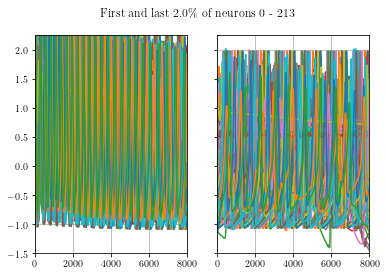

In [41]:
plot_beginning_and_end(vals, 0, 213, 0.02)

In [42]:
print("Finding phase... ", end=" ")
phase = ϕ(sol, t)
print("Found phase")

Finding phase...  Found phase


In [ ]:
χ = chimera(phase, cortices, 0.2)

In [45]:
phase.shape

(400000, 213)

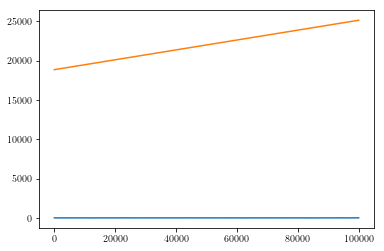

In [44]:
plt.plot(phase[300000:, 0])
plt.plot(phase[300000:, 1])

In [ ]:
phase_window = np.hstack([np.roll(phase)])

In [ ]:
print("Writing... ", end=" ")
with open(f"../../data/{α:0.3f}-{β:0.3f}.pkl", "wb") as f:
    pickle.dump([params, sol, phase], f)

print("Wrote")